# **Installazione Pythorch Geometric**

In [ ]:
import torch
 
def format_pytorch_version(version):
  return version.split('+')[0]
 
TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)
 
def format_cuda_version(version):
  return 'cu' + version.replace('.', '')
 
CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)
 
!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-1.8.1+cu102.html
Looking in links: https://pytorch-geometric.com/whl/torch-1.8.1+cu102.html
Looking in links: https://pytorch-geometric.com/whl/torch-1.8.1+cu102.html
Looking in links: https://pytorch-geometric.com/whl/torch-1.8.1+cu102.html


# **Installazione Igraph**

In [ ]:
pip install python-igraph

# **Installazione Cairo**

In [ ]:
#Al fine di plottare i grafi
!apt-get install libcairo2-dev libjpeg-dev libgif-dev
!pip install pycairo

"apt-get" non Š riconosciuto come comando interno o esterno,
 un programma eseguibile o un file batch.


# **Import**

In [ ]:
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.data import DataLoader
from torch_geometric.data import DataListLoader
from sklearn.metrics import roc_curve, auc, roc_auc_score
import igraph
from igraph import *
from igraph import Graph
from igraph import GraphBase
import numpy as np
import numpy.ma as ma
import os
import random
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
from torch_geometric.nn import GATConv
import time
from os import path as P
from datetime import datetime,timezone
import pytz
import itertools
import gc 
import matplotlib.pyplot as plt
import pandas as pd
from itertools import combinations
import math
import collections

In [ ]:
#Da eseguire soltanto se viene utilizzato un runtime ospitato
def g_drive():
  from google.colab import drive
  drive.mount('/content/drive')

In [ ]:
#Da eseguire soltanto se viene utilizzato un runtime ospitato
path = "/content/drive/My Drive/TesiMagistraleNodePruning/"
g_drive()

Mounted at /content/drive


In [ ]:
#Da eseguire soltanto se viene utilizzato un runtime locale
path = "/Users/andre/OneDrive/Documenti/TesiMagistraleNodePruning/"

In [ ]:
dataset_training = list(np.genfromtxt(path+"ListaGrafiTrainingSoglia26k.txt",dtype=np.dtype(str)))
dataset_validation = list(np.genfromtxt(path+"ListaGrafiValidation.txt",dtype=np.dtype(str)))
path_training= path+"Training/"
path_training_salvataggi= path+"TrainingSalvataggi/"
path_validation= path+"Validation/"
path_validation_salvataggi= path+"ValidationSalvataggi/"
path_evaluation = path+"Evaluation/Evaluation.pt"
path_model_performance = path+"ModelPerformanceEvaluation/DataframeModelPerformance.pt"

# **Creazione Grafi**

In [ ]:
# Chi-squared ([o]bserved, [e]xpected)
def chi(o, e):
    if e == 0:
        return 0
    return (o - e) ** 2 / e

In [ ]:
"""Tale funzione consente di generare il file contenente gli identificativi e le features dei nodi"""
def generate_file_features(G, path):
  max_degree_graph = G.maxdegree()
  average_degree_graph = np.mean(G.degree())
  lcc_graph = G.transitivity_local_undirected()
  lcc_graph = [i if not math.isnan(i) else 0 for i in lcc_graph]
  average_lcc_graph = np.mean(lcc_graph)
  x = np.ndarray((G.vcount(),4))
  for i, node in enumerate(G.vs["name"]):
    normalized_node_degree = G.degree(node) / max_degree_graph
    x[i][0]= normalized_node_degree
    local_clustering_coefficient = G.transitivity_local_undirected(node)
    x[i][1]= local_clustering_coefficient if not math.isnan(local_clustering_coefficient) else 0
    node_chi_degree = chi(G.degree(node), average_degree_graph)
    x[i][2] = node_chi_degree
    node_chi_lcc = chi(x[i][1], average_lcc_graph)
    x[i][3] = node_chi_lcc
  nodes_id = np.array(G.vs["name"]).reshape((G.vcount(),1))
  x_with_nodes_id = np.concatenate((nodes_id,x), axis=1)
  np.savetxt(path+".features", x_with_nodes_id, fmt='%s')

In [ ]:
"""Tale funzione consente di generare il file contenente i target dei nodi"""
def generate_file_target(G, path, id_nodi):
  y = np.ndarray((G.vcount(),))
  nodes_inside_largest_cliques = set()
  largest_cliques = G.largest_cliques()
  for clique in largest_cliques:
    for node in clique:
      nodes_inside_largest_cliques.add(node)
  nodes_inside_largest_cliques = list(nodes_inside_largest_cliques)
  """nodes_inside_largest_cliques, anziché contenere gli indici dei nodi appartenenti alla clique di dimensione massima, conterrà proprio
  l'identificativo di ogni singolo nodo appartenente alla clique di dimensione massima"""
  nodes_inside_largest_cliques = [id_nodi[index_node] for index_node in nodes_inside_largest_cliques]
  for i, node in enumerate(G.vs["name"]):
    if node in nodes_inside_largest_cliques:
      y[i]=1
    else:
      y[i]=0
  np.savetxt(path+".target", y, fmt="%s")

In [ ]:
def crea_grafo(path, path1, graph):
 grafoPrincipaleGiaEsistente=False
 if P.exists(path+graph+".pt"): 
  print("Il Grafo "+graph + " è già presente all'interno della directory locale/remota, dunque lo carico")
  g=torch.load(path+graph+".pt")
  print("Il Grafo è costituito da un numero di Nodi pari a: ", g.vcount())
  print("Il Grafo è costituito da un numero di Archi pari a: ", g.ecount())
  grafoPrincipaleGiaEsistente=True
  
 if grafoPrincipaleGiaEsistente==False:

  print("Il Grafo "+graph +" non è presente all'interno della directory locale/remota, dunque lo creo")
  """Costruisco il Grafo principale considerando gli archi memorizzati all'interno del file .ncol"""
  g=Graph.Read_Ncol(path1+"ncol/"+graph+".ncol", directed=False)
  print("Il Grafo è costituito da un numero di Nodi pari a: ", g.vcount())
  print("Il Grafo è costituito da un numero di Archi pari a: ", g.ecount())
  print("Gli attributi del Grafo appena creato sono: ", g.vs.attribute_names())

  generate_file_features(g,path1+"features/"+graph)
  id_nodi = [g.vs[i]["name"] for i in range(0,g.vcount())]
  generate_file_target(g, path1+"target/"+graph, id_nodi)

  """Acquisisco l'identificativo e le features di ogni singolo nodo del Grafo memorizzate all'interno del file .features"""
  id_features_nodes = np.genfromtxt("{}{}.features".format(path1+"features/", graph),dtype=np.dtype(str))
  """Acquisisco il target (0 o 1) di ogni singolo nodo del Grafo memorizzato all'interno del file .target"""
  target_nodes = np.genfromtxt("{}{}.target".format(path1+"target/", graph),dtype=np.dtype(str))
  """Creo un dizionario costituito da un certo numero di coppie dove ogni singola coppia contiene come chiave l'identificativo del nodo
  e come valore una tupla contenente due informazioni: features del nodo - target (classe reale di appartenenza del nodo)"""
  features={}
  for j,i in enumerate(id_features_nodes):
    features[i[0]]=i[1:], target_nodes[j]
  #print("Dizionario Indice Nodo - Features Nodo - Target Nodo: ",features)
  classi=set() #inserisco le classi (0 e 1) in un set che utilizzeremo dopo per associare un colore ad ogni singola classe
  for k in features.keys():
    classi.add(features[k][1])
  print("classi",classi)
  
  color_dict={}
  colori=["yellow","red"]
  c=0
  for i in classi:
    color_dict[i]=colori[c]
    c=c+1
  c=0
  print("dizionario colori",color_dict)

  """nodi conterrà i nodi del Grafo principale che NON sono None"""
  nodi=[]
  """All'interno del Grafo, come attributi, andiamo ad aggiungere le features di ogni singolo nodo e la classe reale di appartenenza di ogni singolo nodo"""
  for v in g.vs:
    id_nodo=v["name"]
    if id_nodo in features.keys():  
      v["features"]=(features[v["name"]][0]).astype(float)
      v["target"]=(features[v["name"]][1]).astype(float)
      nodi.append(v.index)
  """A questo punto considerando solo ed esclusivamente gli indici dei Nodi presenti in nodi andiamo a costruire un nuovo sottografo
  che andrà a sovrascrivere il Grafo principale. In pratica, così facendo, dal Grafo principale stiamo rimuovendo tutti i Nodi che sono None"""
  g=g.subgraph(nodi)

  g.vs["color"] = [color_dict[str(classe)] for classe in g.vs["target"]]  #aggiungo i colori che servono per il plot del grafo

  print("Il Grafo finale "+graph +" è costituito da un numero di Nodi pari a: ", g.vcount())
  print("Il Grafo finale "+graph +" è costituito da un numero di Archi pari a: ", g.ecount())
  print("Gli attributi del Grafo finale sono: ", g.vs.attribute_names())

  """Memorizzo il Grafo Principale in maniera tale da poterlo riutilizzare successivamente"""
  torch.save(g,path+graph+".pt")
  print("Grafo memorizzato con successo")
 return g

In [ ]:
dizionario_grafi = dict()
temp = []
print("TRAINING")
for graph in dataset_training:
  print("Grafo: ", graph)
  g = crea_grafo(path_training_salvataggi,path_training, graph)
  temp.append(g)
  print("-------------------------------------------------------------------------------------")
dizionario_grafi["Training"]= temp
temp = []
print("VALIDATION")
for graph in dataset_validation:
  print("Grafo: ", graph)
  g = crea_grafo(path_validation_salvataggi,path_validation, graph)
  temp.append(g)
  print("-------------------------------------------------------------------------------------")
dizionario_grafi["Validation"]= temp

TRAINING
Grafo:  bio-CE-GT
Il Grafo bio-CE-GT è già presente all'interno della directory save, dunque lo carico
Il Grafo è costituito da un numero di Nodi pari a:  924
Il Grafo è costituito da un numero di Archi pari a:  3239
-------------------------------------------------------------------------------------
Grafo:  bio-CE-HT
Il Grafo bio-CE-HT è già presente all'interno della directory save, dunque lo carico
Il Grafo è costituito da un numero di Nodi pari a:  2617
Il Grafo è costituito da un numero di Archi pari a:  2985
-------------------------------------------------------------------------------------
Grafo:  bio-CE-LC
Il Grafo bio-CE-LC è già presente all'interno della directory save, dunque lo carico
Il Grafo è costituito da un numero di Nodi pari a:  1387
Il Grafo è costituito da un numero di Archi pari a:  1648
-------------------------------------------------------------------------------------
Grafo:  bio-DM-HT
Il Grafo bio-DM-HT è già presente all'interno della directory 

# **Visualizzazione Grafo**

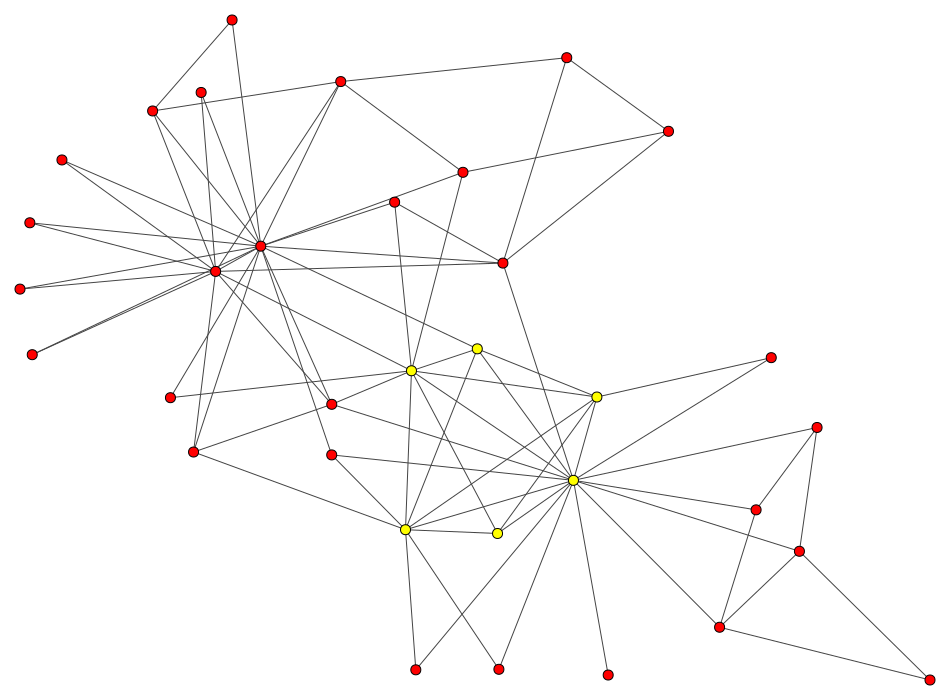

In [ ]:
g = dizionario_grafi["Training"][20]
visual_style = {}
visual_style["vertex_size"] = 10
visual_style["bbox"] = (950, 700)
visual_style["margin"] = 20
#visual_style["vertex_label"] = g.vs["name"]
#visual_style["edge_label"] = g.es.indices
layout = g.layout_auto()
plot(g, layout=layout, **visual_style)

# **Creazione Maschera da utilizzare per il Training e la Validation**

In [ ]:
def crea_maschera_train_val(g, seed, path, graph):
 grafoBilanciatoGiaEsistente=False
 if P.exists(path+"Maschera"+graph+".pt"):
   print("La Maschera del Grafo "+graph + " è già presente all'interno della directory locale/remota, dunque la carico")
   g=torch.load(path+"Maschera"+graph+".pt")
   grafoBilanciatoGiaEsistente=True
   return g
 if grafoBilanciatoGiaEsistente==False:
  random.seed(seed)
  y = torch.empty(size=(g.vcount(),))
  y = g.vs["target"]
  maschera = torch.empty(size=(len(y),))
  number_of_zero = y.count(0)
  number_of_one = y.count(1)
  if number_of_one == number_of_zero: #Il Grafo è già bilanciato dunque non devo mascherare nulla
    maschera.fill(1)
    torch.save(maschera,path+"Maschera"+graph+".pt")
    print("Maschera memorizzata con successo")
    return maschera
  elif number_of_one < number_of_zero:
    index_nodes_label_zero = [node.index for node in g.vs if y[node.index]==0]
    index_remaining_nodes = [node.index for node in g.vs if y[node.index]==1]
    random_indexes_nodes = random.sample(index_nodes_label_zero,number_of_one)
  else:
    index_nodes_label_one = [node.index for node in g.vs if y[node.index]==1]
    index_remaining_nodes = [node.index for node in g.vs if y[node.index]==0]
    random_indexes_nodes = random.sample(index_nodes_label_one,number_of_zero)
  nodes = random_indexes_nodes+index_remaining_nodes
  nodes.sort()
  for i, node in enumerate(g.vs):
    if node.index in nodes:
      maschera[i] = 1
    else:
      maschera[i] = 0
  torch.save(maschera,path+"Maschera"+graph+".pt")
  print("Maschera memorizzata con successo")
  return maschera

In [ ]:
dizionario_maschere_training_validation = dict()
temp = []
print("TRAINING")
for i, graph in enumerate(dataset_training):
  print("Grafo: ", graph)
  m = crea_maschera_train_val(dizionario_grafi["Training"][i], 0, path_training_salvataggi, graph)
  temp.append(m)
  print("-------------------------------------------------------------------------------------")
dizionario_maschere_training_validation["Training"]= temp
temp = []
print("VALIDATION")
for i, graph in enumerate(dataset_validation):
  print("Grafo: ", graph)
  m = crea_maschera_train_val(dizionario_grafi["Validation"][i], 0, path_validation_salvataggi, graph)
  temp.append(m)
  print("-------------------------------------------------------------------------------------")
dizionario_maschere_training_validation["Validation"]= temp

TRAINING
Grafo:  bio-CE-GT
La Maschera del Grafo bio-CE-GT è già presente all'interno della directory, dunque la carico
-------------------------------------------------------------------------------------
Grafo:  bio-CE-HT
La Maschera del Grafo bio-CE-HT è già presente all'interno della directory, dunque la carico
-------------------------------------------------------------------------------------
Grafo:  bio-CE-LC
La Maschera del Grafo bio-CE-LC è già presente all'interno della directory, dunque la carico
-------------------------------------------------------------------------------------
Grafo:  bio-DM-HT
La Maschera del Grafo bio-DM-HT è già presente all'interno della directory, dunque la carico
-------------------------------------------------------------------------------------
Grafo:  bio-DM-LC
La Maschera del Grafo bio-DM-LC è già presente all'interno della directory, dunque la carico
-------------------------------------------------------------------------------------
Grafo:

# **Creazione Dataset**

In [ ]:
def create_data(g, path, graph):
 datasetGiaEsistente=False
 if P.exists(path+"Dataset"+graph+".pt"): 
   print("Il dataset del Grafo "+graph + " è già presente all'interno della directory locale/remota, dunque lo carico")
   data=torch.load(path+"Dataset"+graph+".pt")
   datasetGiaEsistente=True
   return data
 if datasetGiaEsistente==False:
  """Creo la matrice x, ossia la matrice contenente un numero di righe pari al numero di nodi e un numero di colonne pari al
  numero di features di ogni singolo nodo"""
  x=[g.vs[i]["features"] for i in range(0,g.vcount())]
  id_nodi = [g.vs[i]["name"] for i in range(0,g.vcount())]
  x=np.column_stack(tuple([[float(y) for y in x] for x in x]))
  x = torch.from_numpy(x).to(torch.float)
  x=x.t()
  """Creo la matrice edge_index, ossia la matrice che mantiene le informazioni riguardanti gli archi che collegano i diversi nodi"""
  edge_index = np.empty((2, 2 * g.ecount()), dtype=np.int32)
  i = 0
  for e in g.get_edgelist():
    edge_index[:, i] = (g.vs[e[0]].index, g.vs[e[1]].index)
    edge_index[:, i + 1] = (g.vs[e[1]].index, g.vs[e[0]].index)
    i += 2

  if len(edge_index[0])==0:
    edge_index = np.zeros((2, 2), dtype=np.int32)
  
  edge_index = torch.from_numpy(edge_index).to(torch.long)
  
  #Creo la matrice y, la quale conterrà i target associati ai nodi
  y=[]
  for i, node in enumerate(g.vs):
    y.append(node["target"])
  y=torch.FloatTensor(y)

  data = Data(x=x.contiguous(), edge_index=edge_index.contiguous(), y=y.contiguous(), id_nodi=id_nodi)
  torch.save(data,path+"Dataset"+graph+".pt")
  print("Il dataset del Grafo è stato memorizzato con successo")
  return data

In [ ]:
dizionario_dataset = dict()
temp = []
print("TRAINING")
for i, graph in enumerate(dataset_training):
  print("Grafo: ", graph)
  data = create_data(dizionario_grafi["Training"][i], path_training_salvataggi, graph)
  temp.append(data)
  print("-------------------------------------------------------------------------------------")
dizionario_dataset["Training"]= temp
temp = []
print("VALIDATION")
for i, graph in enumerate(dataset_validation):
  print("Grafo: ", graph)
  data = create_data(dizionario_grafi["Validation"][i], path_validation_salvataggi, graph)
  temp.append(data)
  print("-------------------------------------------------------------------------------------")
dizionario_dataset["Validation"]= temp

TRAINING
Grafo:  bio-CE-GT
Il dataset del Grafo bio-CE-GT è già presente all'interno della directory, dunque lo carico
-------------------------------------------------------------------------------------
Grafo:  bio-CE-HT
Il dataset del Grafo bio-CE-HT è già presente all'interno della directory, dunque lo carico
-------------------------------------------------------------------------------------
Grafo:  bio-CE-LC
Il dataset del Grafo bio-CE-LC è già presente all'interno della directory, dunque lo carico
-------------------------------------------------------------------------------------
Grafo:  bio-DM-HT
Il dataset del Grafo bio-DM-HT è già presente all'interno della directory, dunque lo carico
-------------------------------------------------------------------------------------
Grafo:  bio-DM-LC
Il dataset del Grafo bio-DM-LC è già presente all'interno della directory, dunque lo carico
-------------------------------------------------------------------------------------
Grafo:  bio

# **Eseguiamo l'algoritmo di Garbage Collection e svuotiamo la GPU**

In [ ]:
gc.collect()
torch.cuda.empty_cache()

# **Modello**

In [ ]:
from torch.nn import functional as F
from torch.autograd import Variable
class GAT(nn.Module):

  #INIT
  def __init__(self, h_sizes, out_size, inOutDim,head,layerLin,linear):
    super(GAT, self).__init__()
    
    torch.manual_seed(0)
    #Hidden Layers GAT
    self.hidden = nn.ModuleList()
    if h_sizes>1:
      for k in range(h_sizes-1):
          self.hidden.append(GATConv(inOutDim[k]*head[k-1] if k!=0 else inOutDim[k] ,inOutDim[k+1],heads=head[k]))
      # LAST LAYER GAT
      self.hidden.append(GATConv(inOutDim[-1]*head[-2], linear[0],heads=1,concat=False))
    else :
      self.hidden.append(GATConv(inOutDim[0]*head[0], linear[0],heads=1,concat=False))
  
    #FULLY-CONNECTED (LINEAR) LAYERS
    self.fc = nn.ModuleList()
    for k in range(0,layerLin):
        self.fc.append(nn.Linear(linear[k], 1 if k+2>len(linear) else linear[k+1]))

  #FORWARD
  def forward(self, data,device):
    x, edge_index= data.x, data.edge_index
    for layer in self.hidden:
      x = layer(x,edge_index)
      x= F.elu(x)
      
    for layer in self.fc:
      x=layer(x)
      #x=F.relu(x)

    x=torch.sigmoid(x)
  
    x = x.view(x.size(0))
    return x

# **Generazione Modelli**

In [ ]:
featureInputSize=dizionario_dataset["Training"][0].x.size(1)
print(featureInputSize)
outputGat=[20,40]
head=[
      [4,1,1],
      ]
out1=outputGat[0]
out2=outputGat[1]
linear=[
        [out1],
]
c = list(itertools.product(head, linear))#creo tutte le combinazioni tra head e linear

4


In [ ]:
modelli=[]
factor = 1.5
for j,i in enumerate(c):
  inOutDim=[]
  head=i[0]
  linear=i[1]
  outputGat=i[1][0]
  layerGat=len(head) 
  layerLin=len(linear)  

  inOutDim.append(featureInputSize) 
  for i in range(1,layerGat):
    inOutDim.append(round(inOutDim[i-1]/factor))
  m=GAT(layerGat, outputGat ,inOutDim,head,layerLin,linear)
  modelli.append(m)#creo i modelli e li metto nella lista
  m=None

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if P.exists(path_evaluation): #controllo se ci sono i salvataggi
  print("alcune prove sono già state fatte")
  salvataggi=torch.load(path_evaluation, map_location=torch.device(device))
else:
  print("ancora non ci sono prove")
  salvataggi={}

ancora non ci sono prove


# **Train e Validation**

In [ ]:
def accuracy(output, labels):
    assert output.size() == labels.size()
    output = output > 0.5
    preds = output.type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    return correct / float(len(labels))

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs, best_val_accuracy, validation_loss_at_best_val_accuracy, training_loss_at_best_val_accuracy, best_epoch, history_loss, history_accuracy,stoppato):
  
  #Inizializzazione parametri
  epoch_loss={"Training": [], "Validation": []}
  epoch_acc_normale={"Training": [], "Validation": []}
  
  try:
    for epoch in range(num_epochs):
      graph_loss={"Training": [], "Validation": []}
      graph_acc_normale={"Training": [], "Validation": []}
      
      since = time.time()
      print("-" * 150)
      print("Epoch {}/{}".format(epoch+1, num_epochs))
      tz = pytz.timezone('Etc/GMT-2')
      now = datetime.now(tz=tz)
      current_time = now.strftime("%H:%M:%S")
      

      for phase in ["Training", "Validation"]: 
       if phase == "Training":
          model.train()  # Set model to training mode
          torch.set_grad_enabled(True)
       else:
          model.eval()  # Set model to evaluate mode
          torch.set_grad_enabled(False)


       for k, data in enumerate(dataloaders[phase]):
        
        data=data.to(device)
        labels=data.y

        #Resettiamo il gradiente
        optimizer.zero_grad()

        
        outputs = model(data,device)     
        

        maschera = dizionario_maschere_training_validation[phase][k]
        maschera_booleana = maschera.type(torch.bool).to(device)
        outputs = outputs.masked_select(maschera_booleana)
        labels = labels.masked_select(maschera_booleana)
        #LOSS
        loss = criterion(outputs,labels)
        
        graph_loss[phase].append(loss.item())
        
        # backward + optimize solo per la fase di train
        if phase == "Training":
          loss.backward()
          optimizer.step()

        #ACCURATEZZA
        graph_acc_normale[phase].append(accuracy(outputs,labels).item())

       epoch_loss[phase] = np.mean(graph_loss[phase])
       epoch_acc_normale[phase] = np.mean(graph_acc_normale[phase])

       history_loss[phase].append(epoch_loss[phase])
       history_accuracy[phase].append(epoch_acc_normale[phase])  
  
      
      if epoch_acc_normale["Validation"]>best_val_accuracy:
        best_val_accuracy=epoch_acc_normale["Validation"]
        validation_loss_at_best_val_accuracy = epoch_loss["Validation"]
        training_loss_at_best_val_accuracy = epoch_loss["Training"]
        best_epoch = epoch

      
      time_elapsed = time.time() - since
      print("Epoch complete in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60))
  
  except KeyboardInterrupt:
    print("Interrupted")   
    stoppato=True
  print("#"*150)
  print("Best Validation Accuracy: {:.2f}".format(best_val_accuracy))
  print("Validation Loss at best validation accuracy: {:.2f}".format(validation_loss_at_best_val_accuracy))
  print("Training Loss at best validation accuracy: {:.2f}".format(training_loss_at_best_val_accuracy))
  print("Epoch at best validation accuracy: {:.0f}".format(best_epoch))
  return model, best_val_accuracy, validation_loss_at_best_val_accuracy, training_loss_at_best_val_accuracy, best_epoch, optimizer, history_loss, history_accuracy,stoppato

In [ ]:
lr=5e-4
weight_decay=5e-4
betas=(0.5,0.999)
num_epochs=250
for i,m in enumerate(modelli):
  print("MODELLO",i)
  if i<len(salvataggi):pass 
  else :
    stoppato=False
    optimizer = optim.Adam(m.parameters(), lr=lr, betas=betas, weight_decay=weight_decay)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = m.to(device)
    gc.collect()
    torch.cuda.empty_cache()
    criterion=nn.BCELoss()

    best_val_accuracy = 0.0
    validation_loss_at_best_val_accuracy = 0.0
    training_loss_at_best_val_accuracy = 0.0
    best_epoch = 0
    history_loss = {"Training": [], "Validation": []}
    history_accuracy = {"Training": [], "Validation": []}

    model, best_val_accuracy, validation_loss_at_best_val_accuracy, training_loss_at_best_val_accuracy, best_epoch, optimizer,history_loss,history_accuracy,stoppato = train_model(
     model, dizionario_dataset, criterion, optimizer, device, num_epochs,best_val_accuracy, validation_loss_at_best_val_accuracy, training_loss_at_best_val_accuracy, 
     best_epoch, history_loss, history_accuracy, stoppato)

    if stoppato==True:break
    checkpoint = {
              'modello': m,
              'history_loss':history_loss,
              'history_accuracy':history_accuracy,
              'best_validation_accuracy':best_val_accuracy,
              'validation_loss_at_best_val_accuracy':validation_loss_at_best_val_accuracy,
              'training_loss_at_best_val_accuracy':training_loss_at_best_val_accuracy,
              'best_epoch':best_epoch
    }
    salvataggi["modello "+str(i)]=checkpoint
    torch.save(salvataggi,path_evaluation)
    gc.collect()
    torch.cuda.empty_cache()

MODELLO 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch 1/250
Epoch complete in 0m 22s
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch 2/250
Epoch complete in 0m 1s
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch 3/250
Epoch complete in 0m 1s
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch 4/250
Epoch complete in 0m 1s
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch 5/250
Epoch complete in 0m 1s
------------------------------------------------------

# **Valutazione Performance dei Modelli in fase di Training e Validation**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dati=torch.load(path_evaluation, map_location=torch.device(device))
outputGat=[20,40]
head=[
      [4,1,1],
      ]
out1=outputGat[0]
out2=outputGat[1]
linear=[
        [out1],
]
c = list(itertools.product(head, linear))#creo tutte le combinazioni tra head e linear
bestValidationAccuracy = []
ValidationLossAtBestValidationAccuracy=[]
TrainingLossAtBestValidationAccuracy=[]
livelliGat=[]
livelliLinear=[]
"""HeadGATLayers, per ogni singolo modello contiene il valore assunto dal parametro head di ogni singolo layer GAT di quel modello"""
HeadGATLayers = []
"""InputFeaturesLinearLayers, per ogni singolo modello contiene il numero di features che vengono mandate in ingresso ad ogni singolo layer lineare di quel modello"""
InputFeaturesLinearLayers = []
nomeModelli=[]
num=0
for e in c:
  HeadGATLayers.append(e[0])
  InputFeaturesLinearLayers.append(e[1])
  livelliGat.append(len(e[0]))
  livelliLinear.append(len(e[1]))
  bestValidationAccuracy.append(dati["modello "+str(num)]["best_validation_accuracy"])
  ValidationLossAtBestValidationAccuracy.append(dati["modello "+str(num)]["validation_loss_at_best_val_accuracy"])
  TrainingLossAtBestValidationAccuracy.append(dati["modello "+str(num)]["training_loss_at_best_val_accuracy"])
  nomeModelli.append("modello "+str(num))
  num+=1

dataframe={
    "Numero Modello":nomeModelli,
    "Best Validation Accuracy":bestValidationAccuracy,
    "Validation Loss At Best Validation Accuracy":ValidationLossAtBestValidationAccuracy,
    "Training Loss At Best Validation Accuracy": TrainingLossAtBestValidationAccuracy,
    "Numero Livelli Gat":livelliGat,
    "Numero Livelli Lineari":livelliLinear,
    "Head GAT Layers":HeadGATLayers,
    "Input Features Linear Layers":InputFeaturesLinearLayers
}
df = pd.DataFrame (dataframe, columns = dataframe.keys())
torch.save(df,path_model_performance)

In [ ]:
df

,Numero Modello,Best Validation Accuracy,Validation Loss At Best Validation Accuracy,Training Loss At Best Validation Accuracy,Numero Livelli Gat,Numero Livelli Lineari,Head GAT Layers,Input Features Linear Layers
0,modello 0,0.863445,0.53812,0.416574,3,1,"[4, 1, 1]",[20]


Modello 0


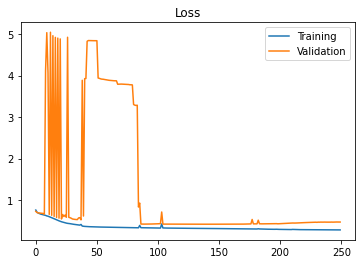

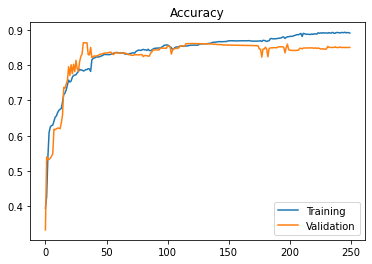

####################################################################################################



In [ ]:
modelli = list(salvataggi.keys())
for i in range(0, len(modelli)):
  print(modelli[i].capitalize())
  #Plot Loss
  plt.title("Loss")
  plt.plot(salvataggi[modelli[i]]["history_loss"]["Training"], label='Training')
  plt.plot(salvataggi[modelli[i]]["history_loss"]["Validation"], label='Validation')
  plt.legend()
  plt.show()
  print("")
  # Plot Accuracy
  plt.title("Accuracy")
  plt.plot(salvataggi[modelli[i]]["history_accuracy"]["Training"], label='Training')
  plt.plot(salvataggi[modelli[i]]["history_accuracy"]["Validation"], label='Validation')
  plt.legend()
  plt.show()
  print("#"*100)
  print("")